# Simulation for Potts model
- No interaction (infinite temperature)
- No field
- Preference for low number of colors

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- We only consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(q^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [1]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/

import numpy as np 
from numpy.random import rand
from scipy.special import binom

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(no_colors, size=(N,N))
    return state


def mc_move(config, eta_prob, parts, parts_prob, N, q):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, q)
#     print('assigned eta:', eta)
    # Assign labels to each site
    config = assign_labels(eta, parts, parts_prob, N, q)
#     print('assigned configuration:\n', config)
    return  config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def calc_energy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.


def calc_mag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag


def prob_eta(gamma, q, k):
    '''Probability of the eta corresponding to a certain number of colors'''
    if k < q:
        return ( np.exp((q-k)*gamma) - np.exp((q-k-1)*gamma) ) / np.exp((q-1)*gamma)
    elif k == q:
        return 1 / np.exp(gamma*(q-1))

    
def lengths_of_partition(partition):
    '''Lengths of equal subtrings in a partition'''
    lengths = []
    cnt = 0
    curr = partition[0]
    for i in range(len(partition)):
        if partition[i] == curr:
            cnt += 1
            if i == len(partition)-1:
                lengths.append(cnt)
        else:
            lengths.append(cnt)
            cnt = 1
            curr = partition[i]
            if i == len(partition)-1:
                lengths.append(cnt)
    return tuple(lengths)


def multinomial(params):
    if len(params) == 1:
        return 1
#     print (sum(params), params[0])
    return binom(sum(params), params[0]) * multinomial(params[1:])


def prob_of_partition(partition, no_sites, no_colors):
    '''Probability of a given partition'''
    p = partition
    l = ll = lengths_of_partition(p)
    if sum(l) < no_colors: ll = l + (no_colors-sum(l),)
    m1 = multinomial(ll)
    m2 = multinomial(p)
#     print(p, m1, m2, m1*m2)
#     print(l)
#     print(ll)
#     print()
    return m1*m2

    
def assign_etas(config, prob, q):
    '''Assign a number of colors that is at least the current number of colors, with correct probabilities'''
    current_k = number_of_colors(config)
#     print('current no. of colors:', current_k)
    p = prob[current_k-1:]
#     print('probabilities for no. of colors:', p)
    p = p / p.sum()
# #     print('normalized:', p)
    return np.random.choice((np.arange(current_k, q+1)), p=p)


def assign_labels(max_colors, parts, prob, N, q):
    '''Assign a color configuration that has at most the corresponding number of eta'''
    # Brute force version
#     config = initial_config(N, q)
#     while number_of_colors(config) > max_colors:
#         config = initial_config(N, q)
#     return config
    
    idx_max_color = len(parts)                  # index of first occurence of a partition with more than max_colors
    for i in range(len(parts)):
        if len(parts[i]) > max_colors:
            idx_max_color = i
            break
    
#     print('max colors:', max_colors)
#     print('partitions:', parts)
#     print('idx of partition with max color:', idx_max_color)
    p = np.array(prob[:idx_max_color])
#     print('probabilities for partitions:', p)
    p = p / p.sum()
#     print('normalized:', p)
    if idx_max_color > 1: chosen_part = np.random.choice(parts[:idx_max_color], p=p)
    else: chosen_part = parts[0]
#     print('chosen partition:', chosen_part)
        
    # Choose the colors to be used
    chosen_colors = np.random.choice(q, len(chosen_part), replace=False)
#     print('chosen colors:', chosen_colors)

    # Choose a random permutation of the given word
    color_arr = []
    for i in range(len(chosen_part)): color_arr += [chosen_colors[i]]*chosen_part[i]
    color_arr = np.array(color_arr)
#     print('color array:\n', color_arr)
    config = np.random.permutation(color_arr).reshape(N,N)
    return config

In [2]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

def init_partitions(N, q):
    session = WolframLanguageSession()
    parts = session.evaluate(wl.IntegerPartitions(N*N,q))
#     print(parts)

    sorted_p = tuple(sorted(parts, key=lambda x: len(x)))
#     print(sorted_p)

    part_prob = tuple([prob_of_partition(p, N*N, q) for p in sorted_p])
#     print(part_prob)
#     print(sum(part_prob), q**(N*N))
#     print(q**(N*N)-sum(part_prob))
    part_prob = tuple(part_prob / sum(part_prob))
#     print(part_prob)
    return sorted_p, part_prob

    session.terminate()

## Experiment routine

In [3]:
# Small experiment

N, q = 3, 4
sorted_p, part_prob = init_partitions(N, q)
gamma = 2.5
print('Initialization done')
print()

eta_prob = np.zeros(q)
for j in range(q):
    eta_prob[j] = prob_eta(gamma,q,j+1)
print('eta probabilities:', eta_prob)

config = initial_config(N,q)
# config = np.array([[0,0],[0,0]])
print('initial config:\n', config)
config = mc_move(config, eta_prob, sorted_p, part_prob, N, q)

Initialization done

eta probabilities: [9.17915001e-01 7.53470516e-02 6.18486263e-03 5.53084370e-04]
initial config:
 [[1 2 0]
 [2 3 3]
 [0 1 2]]


In [4]:
# Stirling numbers of second kind
S = [[0 for i in range(1001)] for j in range(1001)]

# Combinations
C = [[0 for i in range(1001)] for j in range(1001)]

In [5]:
def stirling(n,k,S):
#     print(n,k)
    if S[n][k] > 0: return S[n][k]
    if k>n or k==0 or n==0: return 0
    if k==1 or k==n:
        S[n][k]=1
    else:
        S[n][k] = stirling(n-1,k-1,S) + k*stirling(n-1,k,S)
    return S[n][k]

def combs(n,k,C,S):
    if C[n][k] > 0: return C[n][k]
    if k>n or k==0 or n==0: return 0
    c = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        c*=i
    C[n][k] = c*stirling(n,k,S)
    return C[n][k]

def H(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors
def H_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += k * C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors squared
def H_t_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += (k**2) * C[n][k] * (z**k)
    return h

def E_cols(n,z,C):
    return H_t(n,z,C)/H(n,z,C)

def Var_cols(n,z,C):
    EX_2 = H_t_t(n,z,C)/H(n,z,C)
    v = EX_2 - (E_cols(n,z,C)**2)
#     if v < 0: print("Negative variance in",n,z,C)
    return v

def std_cols(n,z,C):
    return Var_cols(n,z,C)**(0.5)

In [6]:
for i in range(1001):
    if i%100==0: print(i)
    for j in range(1001):
        stirling(i,j,S)
        combs(i,j,C,S)

0
100
200
300
400
500
600
700
800
900
1000


In [19]:
def plot_avg_std_colors (N):
    max_gamma = 15
    gammas = np.linspace(0, max_gamma, num=100)
    z = [np.e**(-gamma) for gamma in gammas]
    y = [E_cols(N,zz,C) for zz in z]
    yerr = [np.real(std_cols(N,zz,C)) for zz in z]
    f = plt.figure(figsize=(18, 5))
    plt.errorbar(gammas, y, yerr=yerr, marker='o', color='black', capsize=3)
    plt.xlabel("Gamma (g)") 
    plt.ylabel("Std. num. colors")
    plt.title(str(N) + " total sites / colors")
#     plt.savefig("Expected_no_colors/avg_std_(" + str(N)+","+str(N)+")_vary_gamma_.png", format="png")
    plt.show()

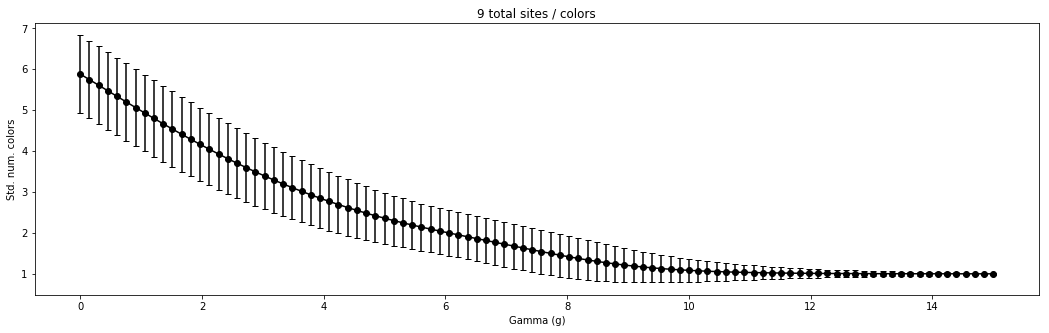

In [20]:
plot_avg_std_colors (9)

## STD and distribution

In [34]:
## change these parameters for a smaller (faster) simulation 
ng       = 201          #  number of gammas to try out
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation


In [37]:
import matplotlib.pyplot as plt

def experiment_for_N_std (N,q):
    '''Run simulation for different gammas given a lattice size
       N = size of the lattice, N x N
       q = number of colors
    '''
    min_gamma, max_gamma = 0, 15
    sorted_p, part_prob = init_partitions(N,q)
    print('Initialization done')
    print()
    gamma = np.linspace(min_gamma, max_gamma, ng);
    eta_probs = np.zeros((ng, q))

    for i in range(ng):
        for j in range(q):
            eta_probs[i][j] = prob_eta(gamma[i],q,j+1)
    
    avg_c, avg_s_c = np.zeros(ng), np.zeros(ng)
    std_c, std_s_c = np.zeros(ng), np.zeros(ng)
    
    saved_c_distribs = []
    saved_s_c_distribs = []

    for g in range(ng):
        tot_c = tot_s_c = 0
        config = initial_config(N,q)
        eta_prob = eta_probs[g]
        no_cols, no_sites = np.zeros(mc_steps), np.zeros(mc_steps)
        print(g, ' - gamma:', gamma[g])
#         print(eta_prob)

        for i in range(eq_steps):           # equilibrate
            config = mc_move(config, eta_prob, sorted_p, part_prob, N, q) # Monte Carlo moves

        for i in range(mc_steps):
            config = mc_move(config, eta_prob, sorted_p, part_prob, N, q)           
            no_cols[i] = number_of_colors(config)       # calculate the energy
            no_sites[i] = avg_sites_per_color(config)         # calculate the magnetisation

            tot_c = tot_c + no_cols[i]
            tot_s_c = tot_s_c + no_sites[i]

#             if i%1000==0: print (i+1, tot_c/(i+1), tot_s_c/(i+1))
        
        if g%10==0:
            saved_c_distribs.append(no_cols)
            saved_s_c_distribs.append(no_sites)
        
#         print(config)
        avg_c[g] = tot_c / (mc_steps)
        avg_s_c[g] = tot_s_c / (mc_steps)
        print(avg_c[g], avg_s_c[g])
        std_c[g] = np.std(no_cols)
        std_s_c[g] = np.std(no_sites)
        print(std_c[g], std_s_c[g])
        
        print()
        
    f = plt.figure(figsize=(18, 5)); # plot the calculated values  
    
    my_max_gamma = 15
    my_gammas = np.linspace(0, my_max_gamma, num=200)
    z = [np.e**(-my_gamma) for my_gamma in my_gammas]
    y = [E_cols(N*N,zz,C) for zz in z]
    yerr = [np.real(std_cols(N*N,zz,C)) for zz in z]
#     f = plt.figure(figsize=(18, 5))
    plt.errorbar(my_gammas, y, yerr=yerr, marker='o', color='black', capsize=3)
#     plt.xlabel("Gamma (g)") 
#     plt.ylabel("Std. num. colors")
    plt.title(str(N*N) + " total sites / colors", fontsize=20)
#     plt.show()

#     sp =  f.add_subplot(2, 1, 1 );
    plt.errorbar(gamma, avg_c, std_c, linestyle='None', capsize=3, marker='o', color='IndianRed')
#     plt.scatter(gamma, avg_c, s=50, marker='o', color='IndianRed')
    plt.xlabel("Gamma (g)", fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.savefig("Simulation_only_colors_vs_exp/avg_std_(" + str(N)+","+str(N)+")_vary_gamma_.png", format="png")


#     sp =  f.add_subplot(2, 1, 2 );
#     plt.errorbar(gamma, avg_s_c, std_s_c, linestyle='None', capsize=3, marker='o', color='RoyalBlue')
# #     plt.scatter(gamma, avg_s_c, s=50, marker='o', color='RoyalBlue')
#     plt.xlabel("Gamma (g)", fontsize=20); 
#     plt.ylabel("Avg. sites per color ", fontsize=20);   plt.axis('tight');
#     plt.savefig("Simulation_only_colors_std_hist/("+str(N)+","+str(q)+")_scatter.png", format="png")
    
#     f = plt.figure(figsize=(18, 10)); # plot the calculated values    
#     for i in range(20):
#         sp =  f.add_subplot(4, 5, i+1);
#         plt.hist(c_d[i],bins=range(int(np.ceil(np.max(avg_c))+3)))
#         plt.title('gamma='+str(np.around(gamma[i*10],decimals=2)))
#         plt.tight_layout()
#         plt.savefig("Simulation_only_colors_vs_exp/("+str(N)+","+str(q)+")_hist_c.png", format="png")

#     g = plt.figure(figsize=(18, 10)); # plot the calculated values    
#     for i in range(20):
#         sp =  g.add_subplot(4, 5, i+1);
#         plt.hist(s_c_d[i],bins=range(int(np.ceil(np.max(avg_s_c))+3)))
#         plt.title('gamma='+str(np.around(gamma[i*10],decimals=2)))
#         plt.tight_layout()
#         plt.savefig("Simulation_only_colors_vs_exp/("+str(N)+","+str(q)+")_hist_s_c.png", format="png")

    plt.show()
    
    return saved_c_distribs, saved_s_c_distribs

Initialization done

0  - gamma: 0.0
5.88955223880597 1.5685394456289892
0.9211394082657423 0.26484782706720633

1  - gamma: 0.075
5.801990049751244 1.5954904051172614
0.9387172468601682 0.28272132297717556

2  - gamma: 0.15
5.750248756218905 1.6134470504619662
0.9548579315603066 0.30058524541141923

3  - gamma: 0.22499999999999998
5.741293532338308 1.6157071783937365
0.9571601437086888 0.2975971732406291

4  - gamma: 0.3
5.690547263681592 1.626833688699349
0.9286807628076134 0.28541626845240997

5  - gamma: 0.375
5.544278606965174 1.6762366737739758
0.9480430758261674 0.3216006310887546

6  - gamma: 0.44999999999999996
5.509452736318408 1.683827292110862
0.920285592166491 0.3119657468264784

7  - gamma: 0.525
5.380099502487562 1.7305543710021196
0.954070613931648 0.3368800207100026

8  - gamma: 0.6
5.374129353233831 1.7308635394456147
0.952257001131031 0.3280534421081022

9  - gamma: 0.6749999999999999
5.272636815920398 1.7687420042643782
0.948052474793983 0.35776845186098133

10  - g

2.0706467661691543 4.394029850746269
0.2562338787104373 0.38435081806565585

86  - gamma: 6.45
1.144278606965174 8.392537313432836
0.3890025540465974 1.5779557371197712

87  - gamma: 6.5249999999999995
2.032835820895522 4.450746268656716
0.17820670515342443 0.2673100577301367

88  - gamma: 6.6
2.0 4.5
0.0 0.0

89  - gamma: 6.675
2.017910447761194 4.473134328358209
0.13262602920312277 0.19893904380468413

90  - gamma: 6.75
2.0 4.5
0.0 0.0

91  - gamma: 6.825
1.2298507462686568 7.965671641791045
0.42073671186194145 1.8933152033787362

92  - gamma: 6.8999999999999995
1.6756218905472637 6.064179104477612
0.5374092415042165 2.2148549693119333

93  - gamma: 6.975
1.0 9.0
0.0 0.0

94  - gamma: 7.05
1.43681592039801 7.034328358208955
0.49599170566134404 2.2319626754760487

95  - gamma: 7.125
1.0 9.0
0.0 0.0

96  - gamma: 7.199999999999999
2.0 4.5
0.0 0.0

97  - gamma: 7.2749999999999995
1.3353233830845772 7.491044776119403
0.47210339105040444 2.12446525972682

98  - gamma: 7.35
2.0 4.5
0.0 0.0

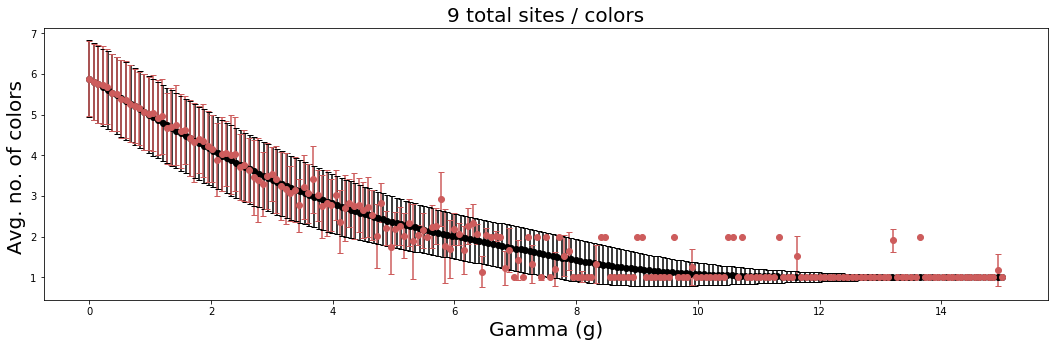

In [41]:
c_d, s_c_d = experiment_for_N_std (3,9)

Initialization done

0  - gamma: 0.0
10.260696517412935 1.5811186270887791
1.1835092066505768 0.19172171121952503

1  - gamma: 0.075
10.261691542288558 1.5832432465268345
1.2467570368094738 0.20061980307283117

2  - gamma: 0.15
10.080597014925374 1.6146187919322286
1.2931013441951287 0.21721747112929304

3  - gamma: 0.22499999999999998
9.929353233830845 1.6373453854050914
1.220057938271088 0.2155547249348453

4  - gamma: 0.3
9.785074626865672 1.6621585158898653
1.2296406138408695 0.2179789508527675

5  - gamma: 0.375
9.74129353233831 1.669970184597055
1.2284910934048665 0.22153225560237305

6  - gamma: 0.44999999999999996
9.528358208955224 1.7156667986518788
1.3605829124812994 0.26105399871502105

7  - gamma: 0.525
9.549253731343283 1.7055382870308289
1.2454142511684376 0.2340467934983708

8  - gamma: 0.6
9.414925373134329 1.731159984294321
1.2474755082503874 0.24537433947206322

9  - gamma: 0.6749999999999999
9.107462686567164 1.7900301136122083
1.2153225847181957 0.2538479687856615



3.225870646766169 5.050746268656739
0.45023748645910694 0.6674711118886058

85  - gamma: 6.375
2.499502487562189 6.73698175787716
0.594543807928441 1.4313584915148356

86  - gamma: 6.45
3.0159203980099503 5.3121061359867126
0.12516764333147373 0.16689019110863162

87  - gamma: 6.5249999999999995
3.2328358208955223 5.022885572139316
0.42263849967014433 0.5635179995601922

88  - gamma: 6.6
3.6865671641791047 4.417910447761212
0.46388866471403145 0.6185182196187085

89  - gamma: 6.675
3.102487562189055 5.196683250414577
0.3032884135366852 0.4043845513822468

90  - gamma: 6.75
3.071641791044776 5.626533996683285
0.8059738345226232 1.6226162714851062

91  - gamma: 6.825
2.9800995024875623 5.411608623548891
0.23940637624095798 0.5508505002081661

92  - gamma: 6.8999999999999995
3.448756218905473 4.846434494195686
0.6755215013452446 1.102050830194067

93  - gamma: 6.975
3.263681592039801 4.981757877280307
0.4406286532434732 0.5875048709912974

94  - gamma: 7.05
3.354228855721393 4.86102819237

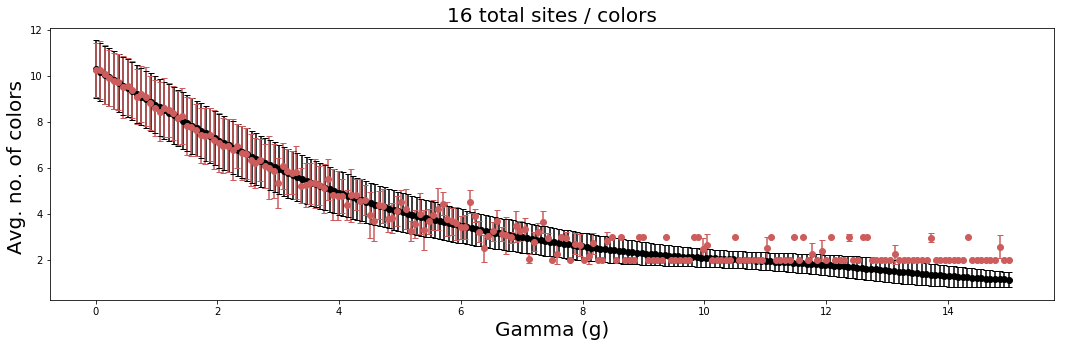

In [38]:
c_d, s_c_d = experiment_for_N_std (4,16)

Initialization done

0  - gamma: 0.0
[[13 11 12 11]
 [ 2  5 10  0]
 [ 2  2 11 13]
 [ 7  2 14  2]]
10.327072927072926 1.5733785583934943
1.2532938913511968 0.2016289167928797

1  - gamma: 0.075
[[ 7 13  6 13]
 [ 5  6  0  0]
 [ 7  6 13  6]
 [ 6  4  0  9]]
10.169230769230769 1.5977004680300884
1.233859756128918 0.2038874054713866

2  - gamma: 0.15
[[10  9  3  9]
 [ 7 14 13 11]
 [ 6 13  4  7]
 [ 1  8 11  6]]
10.1012987012987 1.6095927515707338
1.247546367774987 0.21149834185769606

3  - gamma: 0.22499999999999998
[[ 6  6 15  4]
 [ 5 10 14  3]
 [ 2 14 13  4]
 [11 15 15  6]]
9.946853146853147 1.6355948458245755
1.25888355284076 0.21750221749987786

4  - gamma: 0.3
[[12 11  0  7]
 [13  3  5 13]
 [ 6  6  8 11]
 [ 8  6  6 13]]
9.815384615384616 1.657722435184941
1.2438391941815046 0.22188407818364642

5  - gamma: 0.375
[[ 8  7 15  8]
 [ 1  1  8 10]
 [ 8  1 12 13]
 [ 3 10  9  8]]
9.714285714285714 1.675219130963354
1.2399790990656232 0.22480489792642164

6  - gamma: 0.44999999999999996
[[ 3 13 1

[[ 0 10  6  0]
 [ 6 15 15  9]
 [ 9 15  6 10]
 [ 6 15 15  0]]
5.223376623376623 3.1803688375117107
0.976063669401879 0.6491904059969632

53  - gamma: 3.9749999999999996
[[12 11  3 11]
 [ 6  6 15 11]
 [ 6  3 11  6]
 [15 15  6  3]]
4.97002997002997 3.3235919635920257
0.9125065648366751 0.5872269501878296

54  - gamma: 4.05
[[ 6  6 12 15]
 [ 2 12  6  6]
 [12 12  6  6]
 [15 12  2  6]]
4.699100899100899 3.5576195233339156
0.9579413026224106 0.777364801332624

55  - gamma: 4.125
[[ 2 14  5 12]
 [ 9  5 12  1]
 [12  1 11  9]
 [ 9  1  5  1]]
4.70969030969031 3.508735074449478
0.8399586141724374 0.6455383556516011

56  - gamma: 4.2
[[13  8 10 10]
 [10  8  3 10]
 [ 8  8  3  3]
 [13 10 10 10]]
4.632967032967033 3.575384615384781
0.8512505274310473 0.6876525341629542

57  - gamma: 4.2749999999999995
[[10 10  2 13]
 [ 4 12  2  4]
 [ 4  2 10  2]
 [ 4  2 10 13]]
4.421778221778222 3.736134341848737
0.7941627920174866 0.678217681847812

58  - gamma: 4.35
[[14  3 14  1]
 [ 3  4 14  3]
 [14 14 14  3]
 [ 3 

[[14 14 14  4]
 [ 4  4 14 14]
 [14  4 13 13]
 [13 14  4  4]]
2.9148851148851147 5.787279387279356
0.6467842622592989 1.3828766750949724

107  - gamma: 8.025
[[11  7  1  7]
 [ 7  7 11  7]
 [11  1 11  7]
 [11  1  1 11]]
3.038961038961039 5.322677322677058
0.3152477412166141 0.586882265860235

108  - gamma: 8.1
[[ 1  1  1  1]
 [ 1 12 12 12]
 [ 1  1 12 12]
 [ 1  1 12 12]]
2.2157842157842156 7.45547785547765
0.46430058621140374 1.1310015074233015

109  - gamma: 8.174999999999999
[[13  5  5 13]
 [13 15 13 13]
 [13  5 15  5]
 [15 15 15 13]]
3.0635364635364635 5.2486180486177485
0.24392536017754113 0.32523381357005476

110  - gamma: 8.25
[[14  8 14 14]
 [ 5  5 14  5]
 [14  5  5  8]
 [ 5  5 14  5]]
3.061738261738262 5.393006993006628
0.5204936712034188 1.0260628200587958

111  - gamma: 8.325
[[ 1  1 15  1]
 [ 6  1  6 15]
 [15  1  6  6]
 [ 6  1  1  6]]
2.3276723276723277 7.1262071262070315
0.46936464859438065 1.2516390629183485

112  - gamma: 8.4
[[ 3 14 14 14]
 [14 14 14 14]
 [14  3  3 14]
 [ 3

[[ 1 12 12 12]
 [ 1 12 12 12]
 [12 12 12 12]
 [12 12 12  1]]
2.0 8.0
0.0 0.0

174  - gamma: 13.049999999999999
[[13 13 13 13]
 [13 13 15 13]
 [15 15 13 13]
 [13 15 15 15]]
2.0 8.0
0.0 0.0

175  - gamma: 13.125
[[15  5 15 15]
 [15  5 15  5]
 [15  5 15  5]
 [15 15 15 15]]
2.0 8.0
0.0 0.0

176  - gamma: 13.2
[[2 2 2 6]
 [6 2 2 2]
 [6 2 2 2]
 [6 6 6 2]]
2.0 8.0
0.0 0.0

177  - gamma: 13.275
[[7 5 5 7]
 [7 5 7 7]
 [7 5 5 5]
 [5 7 5 7]]
2.0 8.0
0.0 0.0

178  - gamma: 13.35
[[11 11  4  4]
 [ 4  4  4  4]
 [11  4  4 11]
 [ 4 11 11  4]]
2.0 8.0
0.0 0.0

179  - gamma: 13.424999999999999
[[5 8 8 5]
 [5 5 5 8]
 [5 5 8 5]
 [8 5 8 8]]
2.0 8.0
0.0 0.0

180  - gamma: 13.5
[[9 8 8 9]
 [9 9 9 9]
 [8 9 8 9]
 [9 9 9 8]]
2.0 8.0
0.0 0.0

181  - gamma: 13.575
[[ 1  1 13 13]
 [13 13 13 13]
 [ 1  1  1 13]
 [13 13 13  1]]
2.0 8.0
0.0 0.0

182  - gamma: 13.65
[[0 0 0 0]
 [0 0 0 8]
 [0 0 8 8]
 [0 0 0 8]]
2.0 8.0
0.0 0.0

183  - gamma: 13.725
[[12 12  3  3]
 [ 3 12  3 12]
 [12 12 12 12]
 [ 3  3 12 12]]
2.0 8.0
0.0

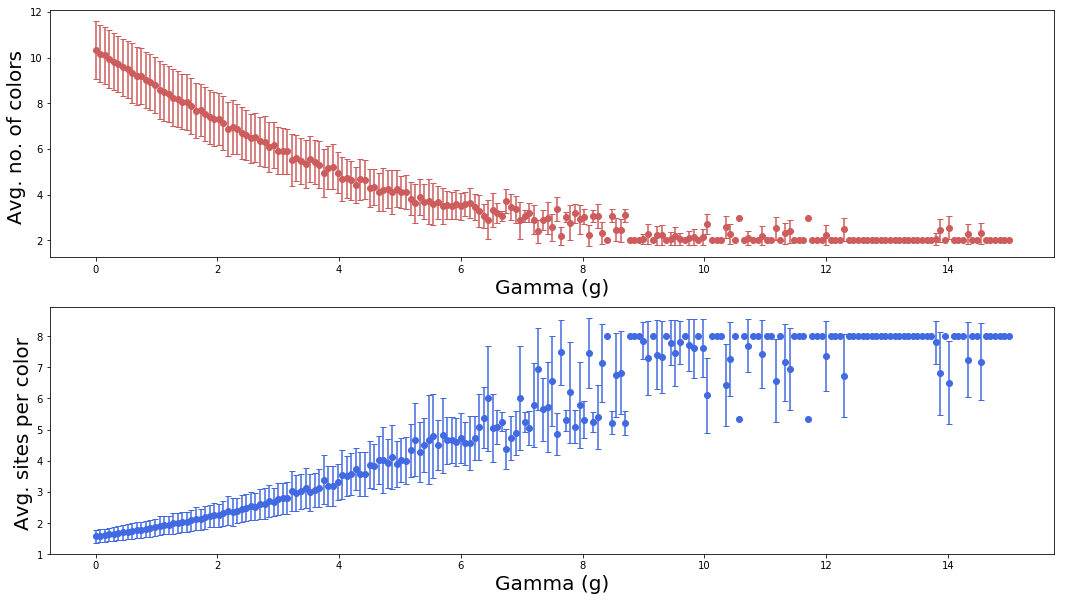

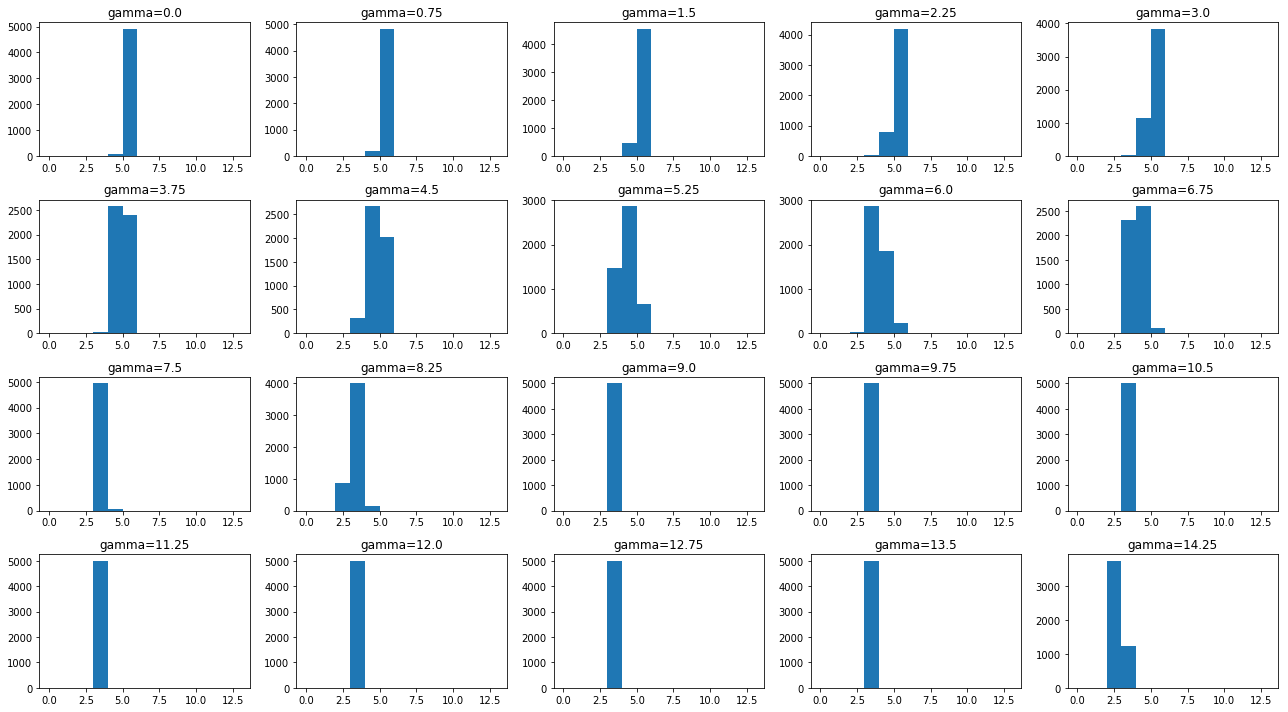

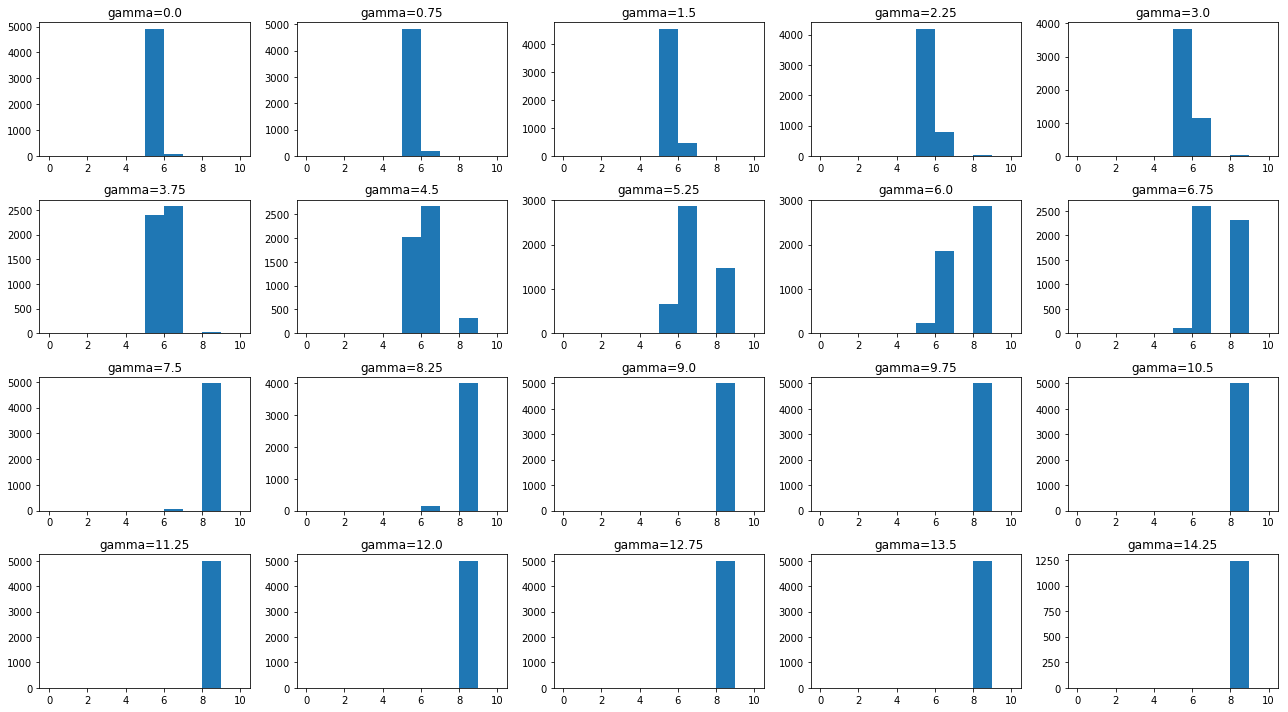

In [73]:
c_d, s_c_d = experiment_for_N_std (4,16)

Initialization done

0  - gamma: 0.0
22.941293532338307 1.5796968557534126
1.8472882689674173 0.13104721395489202

1  - gamma: 0.075
22.61592039800995 1.6017417195504209
1.772017225759922 0.127657549041506

2  - gamma: 0.15
22.48955223880597 1.6113569903897034
1.8162177906824681 0.13225735411583872

3  - gamma: 0.22499999999999998
22.02089552238806 1.64669517445574
1.8695148475483774 0.14100424529337635

4  - gamma: 0.3
21.859701492537315 1.6592631520144938
1.8664937492176121 0.14640552837506762

5  - gamma: 0.375
21.632835820895522 1.677218036632727
1.8946156800352074 0.1506265365823784

6  - gamma: 0.44999999999999996
21.270646766169154 1.7078544567328675
2.006552470164777 0.1644647990707333

7  - gamma: 0.525
21.023880597014927 1.7260360073135685
1.851562971783365 0.15685610321764923

8  - gamma: 0.6
20.930348258706466 1.7317581670955366
1.7228705590650122 0.14395464919497503

9  - gamma: 0.6749999999999999
20.528358208955225 1.7689199126321369
1.8953837062912626 0.16656110974639565

8.616915422885572 4.20566259611036
0.7217394947758841 0.33318471342036027

85  - gamma: 6.375
9.070646766169155 4.012515345351155
0.9153114792689874 0.4381235191807506

86  - gamma: 6.45
5.555223880597015 6.626183368869819
0.8867095384616493 0.9136640473133504

87  - gamma: 6.5249999999999995
6.6985074626865675 5.42899786780381
0.6850556582639346 0.5367685157798122

88  - gamma: 6.6
5.2835820895522385 6.859701492537194
0.4507363841952686 0.5408836610343224

89  - gamma: 6.675
7.399004975124378 4.887064676616964
0.49975019130220594 0.31914127975299517

90  - gamma: 6.75
6.992039800995025 5.149680170575707
0.08886413357916859 0.07616925735357305

91  - gamma: 6.825
6.0 6.0
0.0 0.0

92  - gamma: 6.8999999999999995
6.37910447761194 5.712366737739864
0.7639652996924532 0.5759516910520858

93  - gamma: 6.975
6.0 6.0
0.0 0.0

94  - gamma: 7.05
6.0 6.0
0.0 0.0

95  - gamma: 7.125
7.490547263681592 4.861194029850777
0.8494424270195543 0.4863022026358212

96  - gamma: 7.199999999999999
5.4318407

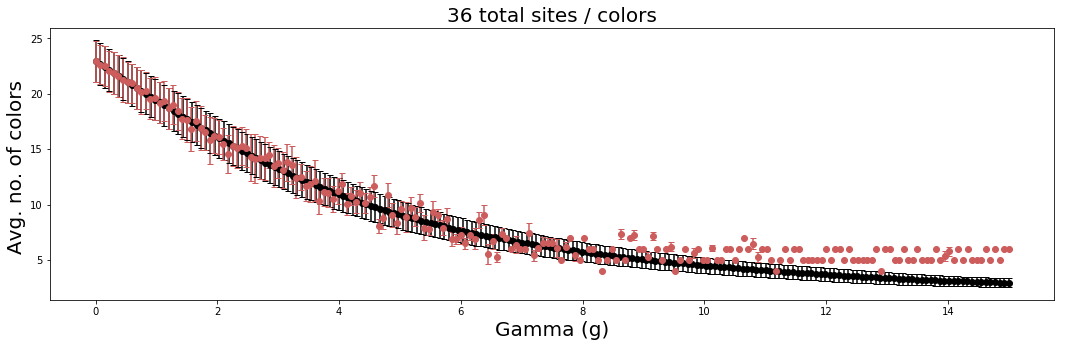

In [39]:
c_d, s_c_d = experiment_for_N_std (6,36)

Initialization done

0  - gamma: 0.0
16.053731343283584 1.5730532582312835
1.5963573296237497 0.16032693680651594

1  - gamma: 0.075
15.783084577114428 1.600238464905076
1.5799466071370656 0.16429603043163526

2  - gamma: 0.15
15.695522388059702 1.6100710081377645
1.6006310480514667 0.17097200497257362

3  - gamma: 0.22499999999999998
15.41592039800995 1.6393398973657567
1.5847988316966621 0.17320203663799513

4  - gamma: 0.3
15.297512437810946 1.65199430849124
1.5727922316930985 0.17435685194898057

5  - gamma: 0.375
15.011940298507463 1.685145952575256
1.5997066635389925 0.18839966258574775

6  - gamma: 0.44999999999999996
15.032835820895523 1.6817447225497943
1.558132706241401 0.18290043001907433

7  - gamma: 0.525
14.612935323383084 1.7311755001643416
1.5729149796255257 0.19146167714436702

8  - gamma: 0.6
14.444776119402984 1.7515342599586634
1.5395887137768065 0.19831553365298435

9  - gamma: 0.6749999999999999
14.42686567164179 1.755667187685692
1.642675474127247 0.2024944536523

4.767164179104477 5.407131011608708
0.8578095544768018 0.9093133408067159

85  - gamma: 6.375
5.506467661691542 4.596422648661476
0.6365391189465567 0.4893223158698492

86  - gamma: 6.45
5.0 5.0
0.0 0.0

87  - gamma: 6.5249999999999995
5.0 5.0
0.0 0.0

88  - gamma: 6.6
5.330348258706468 4.742537313432866
0.5538866544515718 0.5095951924972715

89  - gamma: 6.675
3.8845771144278607 6.575870646766105
0.5612804703901828 0.9929336440673766

90  - gamma: 6.75
4.592039800995025 5.549336650082924
0.6561885410466686 0.7409521327368194

91  - gamma: 6.825
4.268656716417911 5.914179104477612
0.44326096731097003 0.5540762091387127

92  - gamma: 6.8999999999999995
4.1661691542288555 6.04228855721393
0.3722324091367145 0.46529051142089317

93  - gamma: 6.975
5.159203980099503 4.973051409618535
0.8008250491756259 0.8261293110617152

94  - gamma: 7.05
4.669651741293532 5.412935323383085
0.470338480964584 0.5879231012057299

95  - gamma: 7.125
4.065671641791044 6.347844112769421
0.7022817620267622 1.16

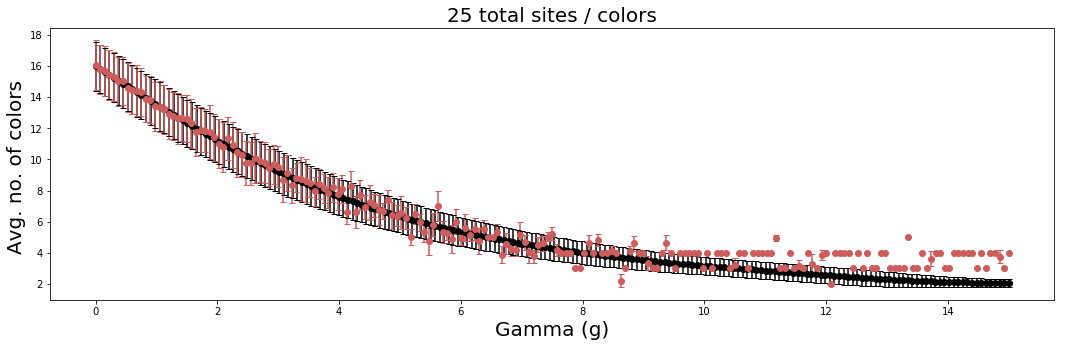

In [40]:
c_d, s_c_d = experiment_for_N_std (5,25)